In [1]:
import numpy as np
import string
import pandas as pd
import nltk
import keras
import logging
logging.getLogger('tensorflow').disabled = True
import tensorflow as tf
import os
import io
import math

# Uncomment below to download files from google drive
# from google.colab import auth
# from googleapiclient.discovery import build
# from googleapiclient.http import MediaIoBaseDownload

from sklearn import random_projection
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import normalize
from nltk.corpus import stopwords

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Embedding, Dense, Dropout, \
    concatenate, Input, Bidirectional, GRU, TimeDistributed, Flatten
from tensorflow.keras.optimizers import SGD, RMSprop
from tensorflow.keras import metrics
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
from keras.preprocessing.text import text_to_word_sequence
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [2]:
nltk.download('stopwords')
nltk.download('punkt')

# This is used for initializing the google drive service
# auth.authenticate_user()
# drive_service = build('drive', 'v3')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [0]:
'''
# This is used for downloading the train, test, valid, etc data from google drive
folder_id = '19noVEHj5FXaVyy-iVgyoa2dmtiy61_VA'
params = {}
children = drive_service.files().list(q="'" + folder_id + "' in parents").execute()
for child in children.get('files', []):
    file_id = child['id']
    request = drive_service.files().get_media(fileId=file_id)
    fh = io.BytesIO()
    downloader = MediaIoBaseDownload(fh, request)
    done = False
    while done is False:
        try:
            status, done = downloader.next_chunk()
        except:
            break
        print("Download %d%%." % int(status.progress() * 100))
    if done:
        with open(child['name'], 'wb') as x:
            x.write(fh.getvalue())
        
print("Download Finished")
'''

Download 26%.
Download 52%.
Download 79%.
Download 100%.
Download 100%.
Download 84%.
Download 100%.
Download 100%.
Download 100%.
Download 100%.
Download Finished


In [16]:
'''
# This is used for downloading the Glove pre-trained word embeddings from google drive
glove_file_id = '1_iIYhqUoMx5TO-HYHx7_wiIVXMjqrzXk'
request = drive_service.files().get_media(fileId=glove_file_id)
fh = io.BytesIO()
downloader = MediaIoBaseDownload(fh, request)
done = False
while done is False:
    status, done = downloader.next_chunk()
    print("Download %d%%." % int(status.progress() * 100))
with open('glove-42B-300d.txt', 'wb') as x:
    x.write(fh.getvalue())
    
print("Download Finished")
'''

Download 2%.
Download 4%.
Download 6%.
Download 8%.
Download 10%.
Download 12%.
Download 14%.
Download 16%.
Download 18%.
Download 20%.
Download 22%.
Download 25%.
Download 27%.
Download 29%.
Download 31%.
Download 33%.
Download 35%.
Download 37%.
Download 39%.
Download 41%.
Download 43%.
Download 45%.
Download 47%.
Download 50%.
Download 52%.
Download 54%.
Download 56%.
Download 58%.
Download 60%.
Download 62%.
Download 64%.
Download 66%.
Download 68%.
Download 70%.
Download 73%.
Download 75%.
Download 77%.
Download 79%.
Download 81%.
Download 83%.
Download 85%.
Download 87%.
Download 89%.
Download 91%.
Download 93%.
Download 95%.
Download 98%.
Download 100%.
Download Finished


In [0]:
stop_words = set(stopwords.words('english') + list(string.punctuation))

In [0]:
# -------------- Helper Functions --------------
def tokenize(text):
    '''
    :param text: a doc with multiple sentences, type: str
    return a word list, type: list
    https://textminingonline.com/dive-into-nltk-part-ii-sentence-tokenize-and-word-tokenize
    e.g.
    Input: 'It is a nice day. I am happy.'
    Output: ['it', 'is', 'a', 'nice', 'day', 'i', 'am', 'happy']
    '''
    tokens = []
    for word in nltk.tokenize.word_tokenize(text):
        word = word.lower()
        if word not in stop_words and not word.isnumeric():
            tokens.append(word)
    return tokens

In [0]:
def get_sequence(data, seq_length, vocab_dict):
    '''
    :param data: a list of words, type: list
    :param seq_length: the length of sequences,, type: int
    :param vocab_dict: a dict from words to indices, type: dict
    return a dense sequence matrix whose elements are indices of words,
    '''
    data_matrix = np.zeros((len(data), seq_length), dtype=int)
    for i, doc in enumerate(data):
        for j, word in enumerate(doc):
            # YOUR CODE HERE
            if j == seq_length:
                break
            word_idx = vocab_dict.get(word, 1) # 1 means the unknown word
            data_matrix[i, j] = word_idx
    return data_matrix

In [0]:
def read_data(file_name, input_length, vocab=None):
    """
    https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html
    """
    df = 0
    if file_name == 'yelp_review_500k.json':
        '''
        yelp_review_500k.json is crafted by sampling the original dataset
        released by yelp (~8GB). The sampling is done by running the following code
            yelp_json_f = open('yelp_review.json', 'r')
            yelp_json_500k_f = open('yelp_review_500k.json', 'w')
            c = 0
            for line in yelp_json_f:
                if random.random() <= 0.6:
                    continue
                if c >= 500000:
                    break
                yelp_json_500k_f.write(eval(line))
                c += 1
            yelp_json_f.close()
            yelp_json_500k_f.close()
        '''
        reviews = []
        x = open(file_name, 'r')
        c = 0
        for line in x:
            if c >= 400000:
                break
            reviews.append(eval(line))
            c += 1
        df = pd.DataFrame(reviews)
    else:
        df = pd.read_csv(file_name)
        
    df['words'] = df['text'].apply(tokenize)

    if vocab is None:
        vocab = set()
        for i in range(len(df)):
            for word in df.iloc[i]['words']:
                vocab.add(word)
    vocab_dict = dict()
    vocab_dict['<pad>'] = 0 # 0 means the padding signal
    vocab_dict['<unk>'] = 1 # 1 means the unknown word
    vocab_size = 2
    for v in vocab:
        vocab_dict[v] = vocab_size
        vocab_size += 1

    data_matrix = get_sequence(df['words'], input_length, vocab_dict)
    '''
    data_matrix2 = np.zeros((len(df['words']), 3), dtype=int)
    for i in range(len(df)):
        data_matrix2[i, 0] = df.iloc[i]['funny']
        data_matrix2[i, 1] = df.iloc[i]['cool']
        data_matrix2[i, 2] = df.iloc[i]['useful']

    data_matrix2 = normalize(data_matrix2)
    '''
    stars = df['stars'].apply(int) - 1
    return df['review_id'], stars, data_matrix, vocab, None, vocab_dict
# ----------------- End of Helper Functions-----------------

In [0]:
def load_data(input_length):
    # Load training data and vocab
    train_id_list, train_data_label, train_data_matrix, vocab, train_data_matrix2, _ = read_data("yelp_review_500k.json", input_length)
    K = max(train_data_label)+1  # labels begin with 0

    # Load valid data
    valid_id_list, valid_data_label, valid_data_matrix, vocab, valid_data_matrix2, _ = read_data("valid.csv", input_length, vocab=vocab)

    # Load testing data
    test_id_list, _, test_data_matrix, _, test_data_matrix2, vocab_dict = read_data("test.csv", input_length, vocab=vocab)
    
    print("Vocabulary Size:", len(vocab))
    print("Training Set Size:", len(train_id_list))
    print("Validation Set Size:", len(valid_id_list))
    print("Test Set Size:", len(test_id_list))
    print("Training Set Shape:", train_data_matrix.shape)
    print("Validation Set Shape:", valid_data_matrix.shape)
    print("Testing Set Shape:", test_data_matrix.shape)

    # Converts a class vector to binary class matrix.
    # https://keras.io/utils/#to_categorical
    train_data_label = keras.utils.to_categorical(train_data_label, num_classes=K)
    valid_data_label = keras.utils.to_categorical(valid_data_label, num_classes=K)
    return train_id_list, train_data_matrix, train_data_label, \
        valid_id_list, valid_data_matrix, valid_data_label, \
        test_id_list, test_data_matrix, None, vocab, \
        train_data_matrix2, valid_data_matrix2, test_data_matrix2, vocab_dict

In [0]:
# Hyperparameters
input_length = 250
embedding_size = 300
hidden_size = 80
batch_size = 512
dropout_rate = 0.2
learning_rate = 0.001
total_epoch = 30

In [9]:
train_id_list, train_data_matrix, train_data_label, \
    valid_id_list, valid_data_matrix, valid_data_label, \
    test_id_list, test_data_matrix, _, vocab, \
    train_data_matrix2, valid_data_matrix2, test_data_matrix2, vocab_dict = load_data(input_length)

Vocabulary Size: 256624
Training Set Size: 400000
Validation Set Size: 10000
Test Set Size: 10000
Training Set Shape: (400000, 250)
Validation Set Shape: (10000, 250)
Testing Set Shape: (10000, 250)


In [0]:
fin = io.open('glove-42B-300d.txt', 'r', encoding='utf-8', newline='\n', errors='ignore')
# n, d = map(int, fin.readline().split())
glove_embeddings = np.zeros((len(vocab_dict), embedding_size))
for line in fin:
    tokens = line.rstrip().split(' ')
    if tokens[0].lower() in vocab_dict:
        glove_embeddings[vocab_dict[tokens[0].lower()]] = list(map(float, tokens[1:]))
fin.close()

In [0]:
# Data shape
N = train_data_matrix.shape[0]
K = train_data_label.shape[1]

input_size = len(vocab) + 2
output_size = K

# fastText_embeddings = normalize(fastText_embeddings)
# print(np.amax(fastText_embeddings))
# print(np.amin(fastText_embeddings))

In [12]:
# fastText_embeddings = ((fastText_embeddings - fastText_embeddings.min()) * (1 / (fastText_embeddings.max() - fastText_embeddings.min())))
assert not np.any(np.isnan(glove_embeddings))
print(np.amax(glove_embeddings))
print(np.amin(glove_embeddings))

2.5168
-4.5811


In [13]:
# New model

# embedding layer and dropout
# YOUR CODE HERE
embed_input = Input(shape=(input_length,), name='words')
# embed_out = Embedding(input_dim=input_size, output_dim=embedding_size, input_length=input_length, weights=[fastText_embeddings])(embed_input)
embed_out = Embedding(input_dim=input_size, output_dim=embedding_size, input_length=input_length, weights=[glove_embeddings], trainable=False)(embed_input)
dropout = Dropout(dropout_rate)(embed_out)

# LSTM layer
# YOUR CODE HERE
gru_out = Bidirectional(GRU(units=hidden_size*2, dropout=dropout_rate, return_sequences=True, kernel_regularizer=keras.regularizers.l2(1e-5)))(dropout)
tdl = TimeDistributed(Dense(120))(gru_out)
gru_out2 = Bidirectional(GRU(units=hidden_size, dropout=dropout_rate, kernel_regularizer=keras.regularizers.l2(1e-5)))(tdl)
# dropout2 = Dropout(dropout_rate)(flat)

# aux_input = Input(shape=(3,), name='cool_funny_useful')
# flat = Flatten()(td)
# x = concatenate([gru_out3, aux_input])
# x = Dropout(dropout_rate)(gru_out2)
x = Dense(40)(gru_out2)
# x = Dropout(dropout_rate)(x)

# output layer
# YOUR CODE HERE
main_out = Dense(K, activation='softmax')(x)

model = Model(embed_input, main_out)

model.summary()


# SGD optimizer with momentum
# optimizer = SGD(lr=learning_rate, decay=1e-6, momentum=0.9, nesterov=True)
optimizer = RMSprop(lr=learning_rate)

reduce_lr = ReduceLROnPlateau(monitor='val_acc', factor=0.3, patience=3, min_lr=0.000001, verbose=1, min_delta=0.005)
# checkpoint = ModelCheckpoint('checkpointbest.hf5', verbose=0, monitor='val_acc', save_best_only=True, mode='auto')
# compile model
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])


tpu_model = tf.contrib.tpu.keras_to_tpu_model(
    model,
    strategy=tf.contrib.tpu.TPUDistributionStrategy(
        tf.contrib.cluster_resolver.TPUClusterResolver(
            tpu='grpc://' + os.environ['COLAB_TPU_ADDR'])
    )
)

# training
# tpu_model.fit([train_data_matrix, train_data_matrix2], train_data_label, epochs=total_epoch, batch_size=batch_size, validation_data=([valid_data_matrix, valid_data_matrix2], valid_data_label))
history = tpu_model.fit(train_data_matrix, train_data_label, epochs=total_epoch, batch_size=batch_size, validation_data=(valid_data_matrix, valid_data_label), callbacks=[reduce_lr,])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
words (InputLayer)           (None, 250)               0         
_________________________________________________________________
embedding (Embedding)        (None, 250, 300)          76987800  
_________________________________________________________________
dropout (Dropout)            (None, 250, 300)          0         
_________________________________________________________________
bidirectional (Bidirectional (None, 250, 320)          442560    
_________________________________________________________________
time_distributed (TimeDistri (None, 250, 120)          38520     
_________________________________________________________________
bidirectional_1 (Bidirection (None, 160)               96480     
_________________________________________________________________
dense_1 (Dense)              (None, 40)                6440      
__________

In [14]:
# testing
# train_score = model.evaluate([train_data_matrix, train_data_matrix2], train_data_label, batch_size=batch_size)
train_score = tpu_model.evaluate(train_data_matrix, train_data_label, batch_size=batch_size)
print('Training Loss: {}\n Training Accuracy: {}\n'.format(train_score[0], train_score[1]))
# valid_score = model.evaluate([valid_data_matrix, valid_data_matrix2], valid_data_label, batch_size=batch_size)
valid_score = tpu_model.evaluate(valid_data_matrix, valid_data_label, batch_size=batch_size)
print('Validation Loss: {}\n Validation Accuracy: {}\n'.format(valid_score[0], valid_score[1]))

# predicting
test_pre = tpu_model.predict(test_data_matrix, batch_size=batch_size).argmax(axis=-1) + 1
sub_df = pd.DataFrame()
sub_df["review_id"] = test_id_list
sub_df["pre"] = test_pre
sub_df.to_csv("pre.csv", index=False)

400000/400000 [==============================] - 103s 258us/sample - loss: 0.6193 - acc: 0.7442
Training Loss: 0.6193218816566467
 Training Accuracy: 0.7441675066947937

10000/10000 [==============================] - 2s 189us/sample - loss: 0.7082 - acc: 0.7151
Validation Loss: 0.7082001089096069
 Validation Accuracy: 0.7150999903678894



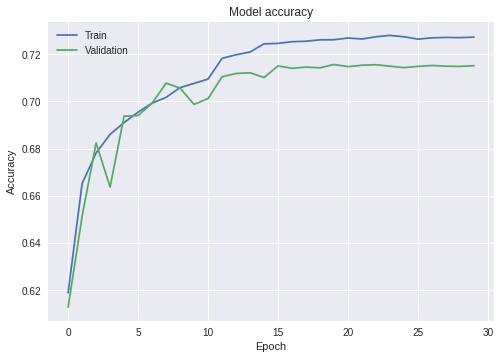

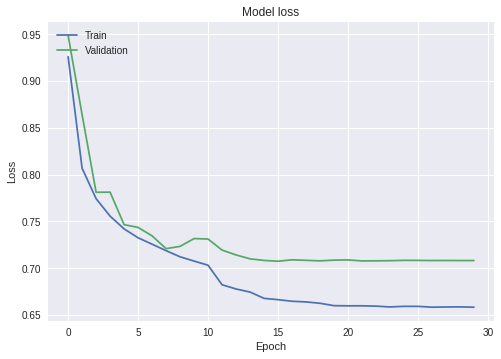

In [15]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [0]:
import h5py
tpu_model.save('asg1_model.hf5')